# import 

In [60]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import gc
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

from tqdm import tqdm_notebook
from multiprocessing import cpu_count

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [61]:
PATH = os.path.join('..', 'input')

# read

In [62]:
train = pd.read_csv(os.path.join(PATH, 'train.csv'))
test = pd.read_csv(os.path.join(PATH, 'test.csv'))

In [63]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [64]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


# feature engineering

In [125]:
for i in train.columns[1:]:
    for j in train.columns[1:]:
        if i == j:
            continue
        train[f'{i}_{j}'] = train[i] * train[j]
        test[f'{i}_{j}'] = test[i] * test[j]

# preprocess

In [124]:
y = train['target']

not_use_cols = ['ID_code', 'target']
use_cols = [c for c in train.columns if c not in not_use_cols]

X = train[use_cols]
X_test = test[use_cols]

# model 

## settings

In [126]:
SEED = 6

NFOLDS = 4

## params

In [127]:
params_in_train = {
    'num_boost_round': 10000,
    'early_stopping_rounds': 200,
    'verbose_eval': 500,
}

In [128]:
params = {
    'boosting': 'gbdt',
    'metric': 'auc',
    'objective': 'binary',
    'max_depth': -1,
    'num_leaves': 9,
    'min_data_in_leaf': 32,
    'bagging_freq': 5,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'sub_sample': 0.6,
    'reg_alpha': 2,
    'reg_lambda': 5,
    'min_gain_to_split': 0.01,
    'min_child_wight': 19,
    'num_threads': cpu_count(),
    'verbose': -1,
    'seed': SEED, # int(2**fold_n),
    'bagging_seed': SEED, # int(2**fold_n),
    'drop_seed': SEED, # int(2**fold_n),
}

## cv

In [129]:
kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

oof = np.zeros(len(X))
predictions = np.zeros(len(X_test))
scores = {'train': [], 'valid': []}
features = X.columns
feature_importance_df = pd.DataFrame(columns=['fold', 'feature', 'importance'])

for fold, (train_index, valid_index) in enumerate(kf.split(X, y)):
    print('fold: {}/{}'.format(fold+1, kf.n_splits))
    
    dtrain = lgb.Dataset(X.iloc[train_index], label=y.iloc[train_index])
    dvalid = lgb.Dataset(X.iloc[valid_index], label=y.iloc[valid_index])
    
    model = lgb.train(params, dtrain, valid_sets=[dtrain, dvalid], **params_in_train)
    scores['train'].append(model.best_score['training']['auc'])
    scores['valid'].append(model.best_score['valid_1']['auc'])
    oof[valid_index] = model.predict(X.iloc[valid_index], num_iteration=model.best_iteration)

    fold_feature_importance_df = pd.DataFrame(columns=['fold', 'feature', 'importance'])
    fold_feature_importance_df['feature'] = features
    fold_feature_importance_df['importance'] = model.feature_importance()
    fold_feature_importance_df['fold'] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_feature_importance_df], axis=0)

    predictions += model.predict(X_test, num_iteration=model.best_iteration) / NFOLDS

cv_score = roc_auc_score(y, oof)**0.5
print('Num folds: {}'.format(NFOLDS))
print('Train Scores: mean {:.5f}, max {:.5f}, min {:.5f}, std {:.5f}'.format(
    np.mean(scores['train']), np.max(scores['train']), np.min(scores['train']), np.std(scores['train'])))
print('Valid Scores: mean {:.5f}, max {:.5f}, min {:.5f}, std {:.5f}'.format(
    np.mean(scores['valid']), np.max(scores['valid']), np.min(scores['valid']), np.std(scores['valid'])))
print('CV Score: {:<8.5f}'.format(cv_score))

fold: 1/4
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.848474	valid_1's auc: 0.831375
[1000]	training's auc: 0.881061	valid_1's auc: 0.859982
[1500]	training's auc: 0.89713	valid_1's auc: 0.873275
[2000]	training's auc: 0.907461	valid_1's auc: 0.881105
[2500]	training's auc: 0.914663	valid_1's auc: 0.886453
[3000]	training's auc: 0.920097	valid_1's auc: 0.889994
[3500]	training's auc: 0.924418	valid_1's auc: 0.892767
[4000]	training's auc: 0.927874	valid_1's auc: 0.894737
[4500]	training's auc: 0.9307	valid_1's auc: 0.896168
[5000]	training's auc: 0.933148	valid_1's auc: 0.897286
[5500]	training's auc: 0.935383	valid_1's auc: 0.898106
[6000]	training's auc: 0.937372	valid_1's auc: 0.89871
[6500]	training's auc: 0.939387	valid_1's auc: 0.899226
[7000]	training's auc: 0.941249	valid_1's auc: 0.899469
[7500]	training's auc: 0.943092	valid_1's auc: 0.899636
[8000]	training's auc: 0.944948	valid_1's auc: 0.89982
[8500]	training's auc: 0.946766	valid

## feature importance

In [130]:
feature_importance_df.head()

,fold,feature,importance
0,1,var_0,507
1,1,var_1,531
2,1,var_2,521
3,1,var_3,176
4,1,var_4,163


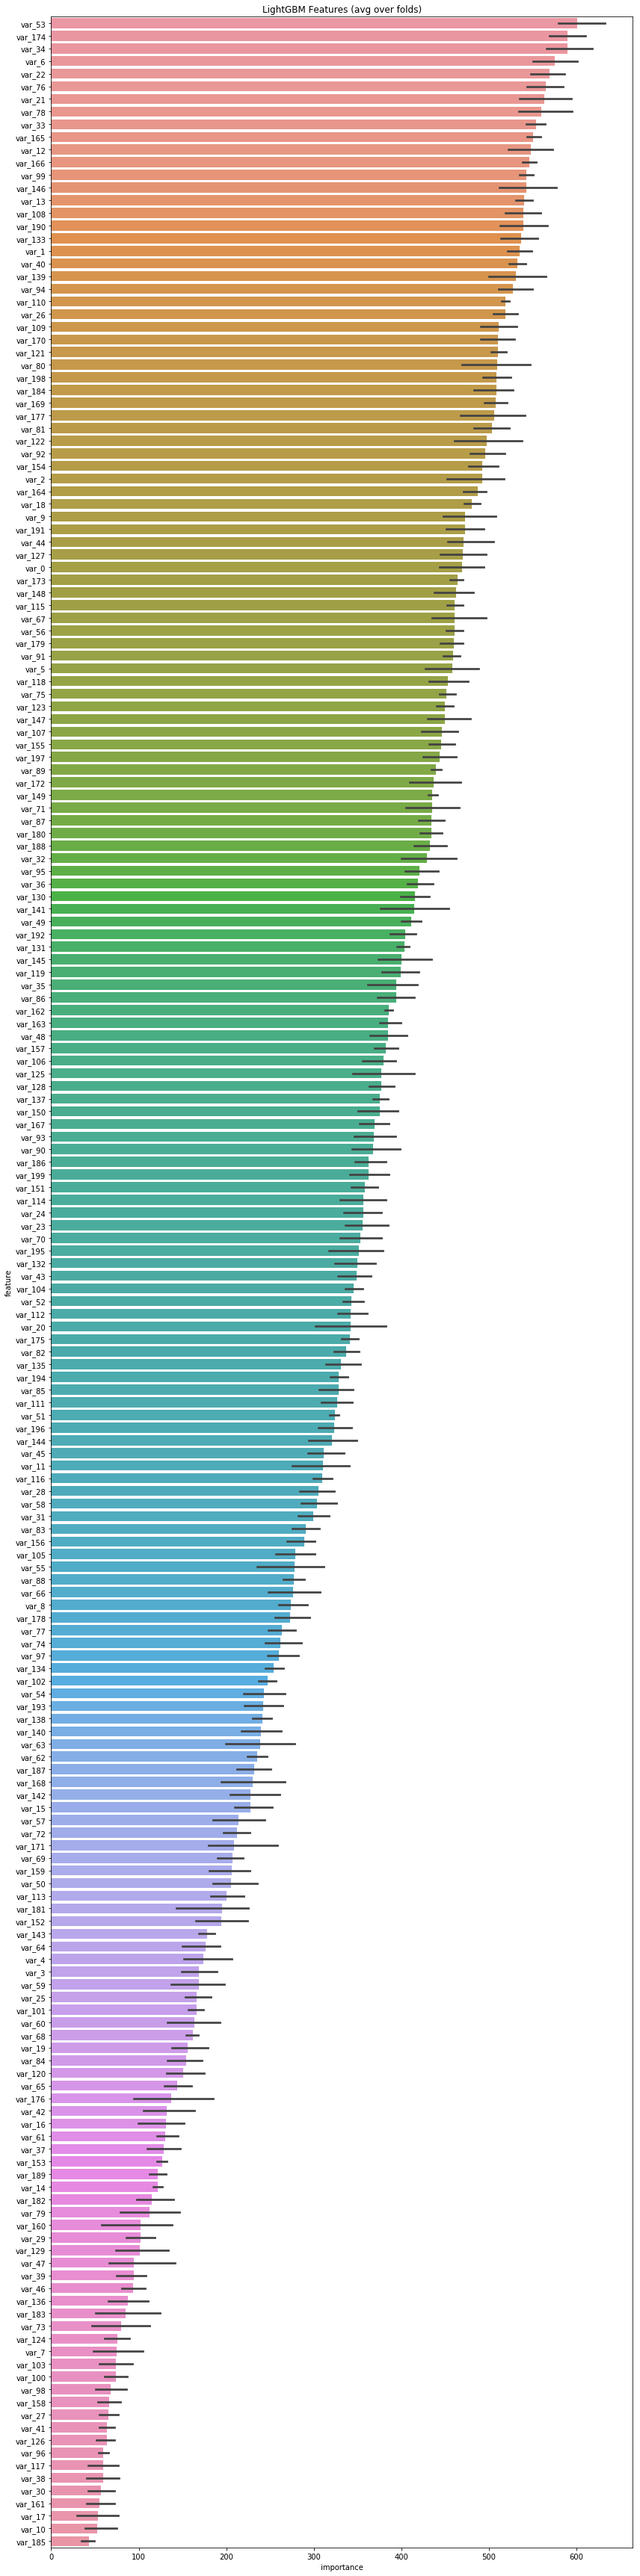

In [136]:
feature_importance_df['importance'] = feature_importance_df['importance'].astype('int')
mean = feature_importance_df['importance'].mean()
std = feature_importance_df['importance'].std()
width = 24
ordered_feature = feature_importance_df.groupby(['feature'])['importance'].mean().sort_values(ascending=False).index
plt.figure(figsize=(12, 48))
sns.barplot(x='importance', y='feature', data=feature_importance_df, order=ordered_feature)
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.vlines(mean, -width, width, colors='red')
# plt.vlines(mean+std, -width, width, colors='red', linestyles=':')
plt.show()

# submission

In [141]:
max(predictions)

0.9934053220681188

In [142]:
min(predictions)

7.194722969231062e-05

In [143]:
sample_submission = pd.read_csv(os.path.join(PATH, 'sample_submission.csv'))

In [144]:
sample_submission['target'] = predictions

In [145]:
sample_submission.head()

,ID_code,target
0,test_0,0.083875
1,test_1,0.217320
2,test_2,0.218311
3,test_3,0.163544
4,test_4,0.048166


In [146]:
sample_submission.to_csv(os.path.join('..', 'submission', 'baseline_0305.csv'), index=False)

# memo

上位の交互作用特徴量の使用

In [147]:
kernel = pd.read_csv(os.path.join('..', 'submission', 'kernel_lgb.csv'))

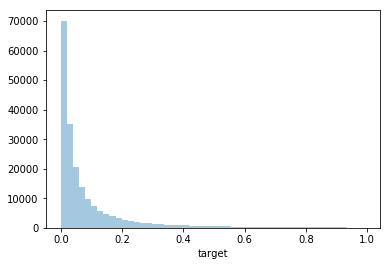

In [149]:
sns.distplot(sample_submission['target'], kde=False)
plt.show()

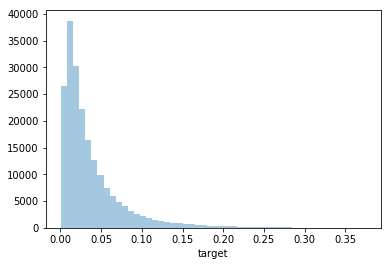

In [112]:
sns.distplot(kernel['target'], kde=False)
plt.show()